Libraries import

In [20]:
import os
import glob
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



In [4]:
csv_data = pd.read_csv(os.getcwd()+'/source_data/lgg-mri-segmentation/kaggle_3m/data.csv')
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [5]:
csv_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [7]:
mask_files = glob.glob(os.getcwd()+"/source_data/lgg-mri-segmentation/kaggle_3m/*/*_mask*")
train_files = [file.replace('_mask', '') for file in mask_files]

In [10]:
# Parse each mask image with lambda function. Max value in mask img indicates abnormality
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'

    
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

del mask_files, train_files  # Clean memory space

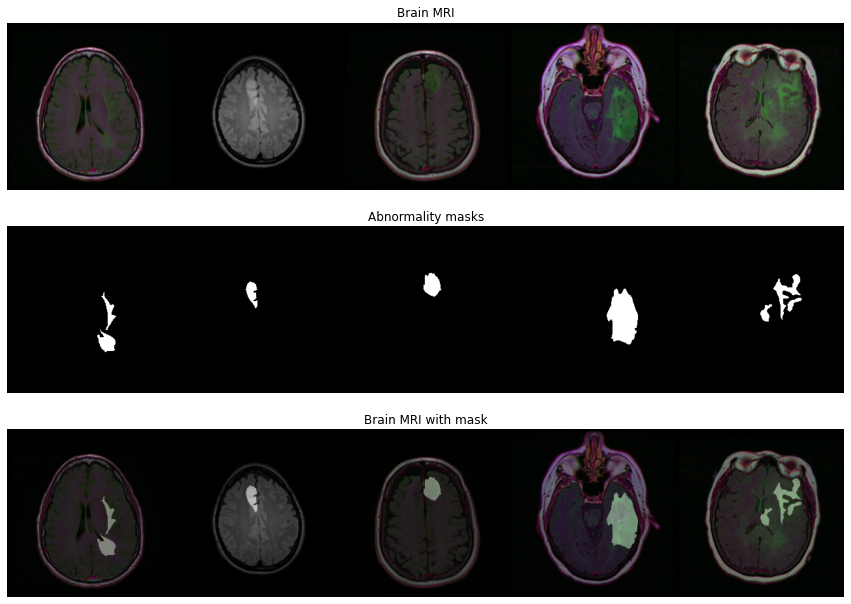

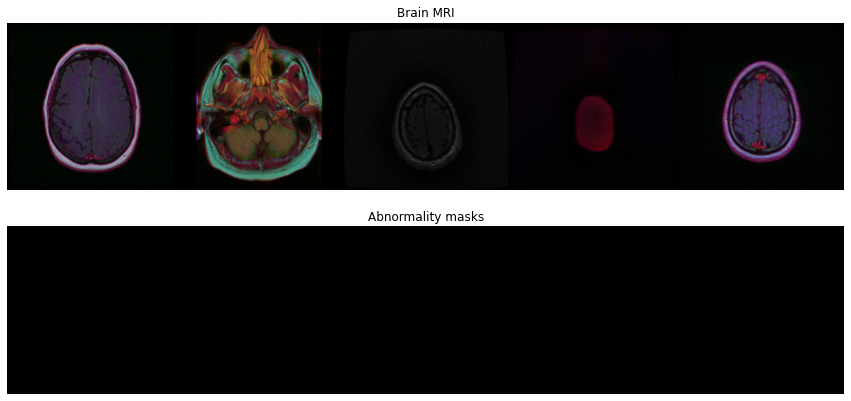

In [19]:
IMAGE_SIZE = (256, 256)

df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(15,15))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Brain MRI', fontsize=12)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Abnormality masks', fontsize=12)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.35)
        grid[2].set_title('Brain MRI with mask', fontsize=12)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

Split data into train/test

In [21]:
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


In [22]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)